<a href="https://colab.research.google.com/github/nikishkaaa/ML-Course/blob/main/%22HW_2_4_kNN_%D0%9A%D1%80%D0%BE%D1%81%D0%B2%D0%B0%D0%BB%D1%96%D0%B4%D0%B0%D1%86%D1%96%D1%8F_%D1%96_%D1%82%D1%8E%D0%BD%D0%B8%D0%BD%D0%B3_%D0%B3%D1%96%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%96%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [6]:
!pip install opendatasets --upgrade --quiet

In [60]:
import pandas as pd
import numpy as np
import os
import opendatasets as od
from sklearn.neighbors import KNeighborsClassifier
from process_bank_churn import preprocess_data
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [8]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: darianikishkina
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 65.5MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [14]:
os.listdir('bank-customer-churn-prediction-dlu')

['train.csv', 'sample_submission.csv', 'test.csv']

In [16]:
df = pd.read_csv('./bank-customer-churn-prediction-dlu/train.csv')
df.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [9]:
numeric_cols = [
 'Age',
 'Balance',
 'CreditScore',
 'IsActiveMember',
 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender','NumOfProducts' ]

In [31]:
data =  preprocess_data(df, 'Exited', scaler_numeric=True, categorical_cols=categorical_cols,numeric_cols = numeric_cols)
X_train = data['X_train']
train_targets = data['train_targets']
X_val = data['X_val']
val_targets = data['val_targets']

In [36]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_val)

print("Train ROC AUC", roc_auc_score(train_targets, train_preds))
print("Val ROC AUC", roc_auc_score(val_targets, test_preds))

Train ROC AUC 0.8401217087657766
Val ROC AUC 0.7822038548597298


Висновок: модель працює добре. Різниця між ROC AUC на тренувальному і валідаційному наборі невелика, отже модель добре генералізується на нових данних

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

## Пошук параметрів за допомогою GridSearchCV

In [74]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 9, 10, 12],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


def grid_search(param_grid, estimator):
        grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,
                                  scoring='roc_auc', cv=5, verbose=0, n_jobs=-1)

        grid_search.fit(X_train, train_targets)
        best = grid_search.best_estimator_
        best_predictions_train = best.predict(X_train)
        best_predictions_test = best.predict(X_val)

        print("Best params: ", grid_search.best_params_)
        print("Best AUROC for Train: ", roc_auc_score(train_targets, best_predictions_train ))
        print("Best AUROC for Test: ", roc_auc_score(val_targets, best_predictions_test))
        return best
grid_search(param_grid, knn)

Best params:  {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}
Best AUROC for Train:  0.7984814552611164
Best AUROC for Test:  0.7685986693188833


KNeighborsClassifier(metric='manhattan', n_neighbors=12)

Висновок: за допомогою GrudSearchCV не знайдемо кращих параметрів для KNN. Модель з параметрами за замовченням має кращий AUROC

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [68]:
param_grid = {
    'max_depth': [1, 3, 5, 7, 9, 11, 15, 17, 20],
    "max_leaf_nodes": [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

clf = DecisionTreeClassifier(random_state=42)
grid_search(param_grid, clf)

Best params:  {'max_depth': 5, 'max_leaf_nodes': 10}
Best AUROC for Train:  0.8126948211693974
Best AUROC for Test:  0.8083990671513822


DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=42)

#### Best model

In [78]:
param_grid = {
    'max_depth': [1, 3, 5, 7, 9, 11, 15, 17, 20],
    "max_leaf_nodes": [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                                  scoring='roc_auc', cv=5, verbose=0, n_jobs=-1)
grid_search.fit(X_train, train_targets)
best = grid_search.best_estimator_
best_predictions_train = best.predict(X_train)
best_predictions_test = best.predict(X_val)

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

## Пошук параметрів за допомогою RandomizedSearchCV

In [64]:
def random_search(estimator, param_dist):
        random_search = RandomizedSearchCV(estimator=estimator, param_distributions=param_dist,
                                              n_iter=40, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1, random_state=42)
        random_search.fit(X_train, train_targets)
        best = random_search.best_estimator_
        best_predictions_train = best.predict(X_train)
        best_predictions_test = best.predict(X_val)

        print("Best params: ", random_search.best_params_)
        print("Best AUROC for Train: ", roc_auc_score(train_targets, best_predictions_train ))
        print("Best AUROC for Test: ", roc_auc_score(val_targets, best_predictions_test))
        return best

In [62]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [65]:
%%time
random_search(clf, params_dt)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params:  {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}
Best AUROC for Train:  0.8002067295852606
Best AUROC for Test:  0.7940805267851018
CPU times: user 197 ms, sys: 19.8 ms, total: 217 ms
Wall time: 1.54 s


DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)

Висновок: модель з параметрами, які знайшов GridSearchCV краще працює. З параметрів на якість моделі краще впливають : max_depth, max_leaf_nodes, criterion

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [66]:
data_dir = './bank-customer-churn-prediction-dlu'
test_csv = data_dir + '/test.csv'
test_raw_df = pd.read_csv(test_csv)
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [69]:
from process_bank_churn import preprocess_new_data

In [71]:
data_dir = './bank-customer-churn-prediction-dlu'
test_csv = data_dir + '/test.csv'
test_raw_df = pd.read_csv(test_csv)
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [79]:
new_data = preprocess_new_data(test_raw_df, data['preprocessor'])
y_pred_proba = best.predict_proba(new_data)[:, 1]

In [81]:
test_raw_df['Exited'] = y_pred_proba

In [80]:
sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv')
sample_submission.head(5)

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [88]:
merged_df = sample_submission.merge(test_raw_df, on='id', how='left')
merged_df.head(5)

,id,Exited_x,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited_y
0,15000,0.5,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.144330
1,15001,0.5,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.020862
2,15002,0.5,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.020862
3,15003,0.5,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.636964
4,15004,0.5,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.020862


In [89]:
merged_df['Exited'] = merged_df['Exited_y']
merged_df = merged_df[['id', 'Exited']]

In [90]:
merged_df.to_csv('submission_knn.csv', index=False)

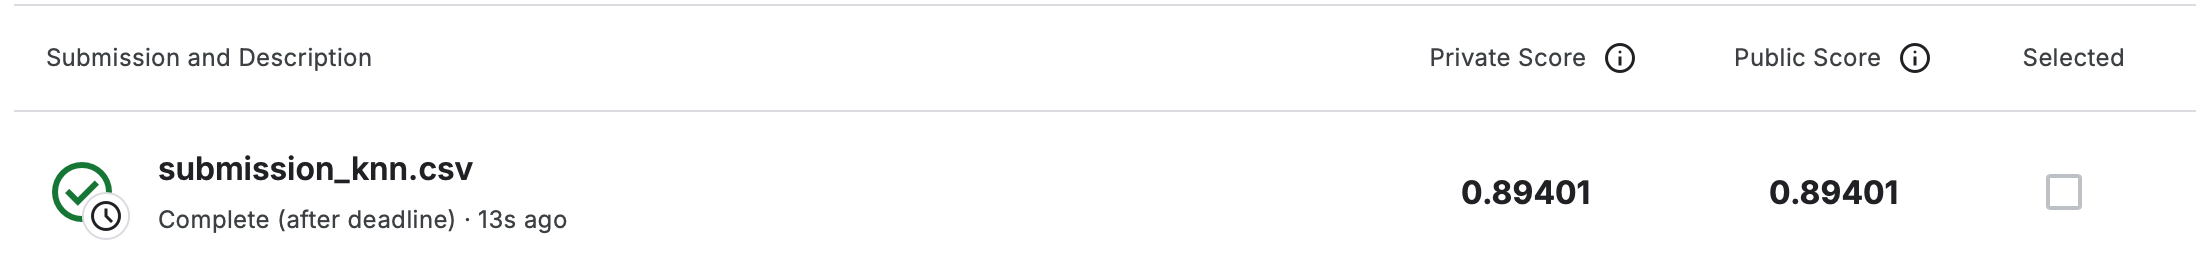